## Historical Simulation

역사적 시뮬레이션은 전략 혹은 자산 보유에 대해서 과거로 되돌아가 진행되었을 때의 성과를 추정하는 방법이다. 전략을 이 시뮬레이션에 적용하는 경우, 선견 편향, 승자 편향 등의 백테스팅 오류에 범할 가능성이 존재함을 염두에 두고 있어야 한다. 그러나, 다른 전략과의 비교가 쉽고 직관적이라 산업 전반에 걸쳐 기본적으로 사용된다.

이번 시간에는 역사적 시뮬레이션을 '잘 하는' 방법에 대해서 알아보도록 한다.

In [44]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf

In [45]:
data = yf.download(
    'SPY',
    start = '2019-12-31',
    progress = False,
    interval = '1d',
    multi_level_index = False,
    auto_adjust = True
)

### 1. Lump-sum Simulation

Lump-Sum Investment (일시불 투자)는 투자 시작 시점에 모든 자금을 한꺼번에 투자하는 방식이다. 즉, 초기에 큰 금액을 한 번에 투입하고, 이후 추가 투자 없이 보유만 하는 시뮬레이션으로 Buy and Hold 전략이다. 이 경우 성과는 초기 투자 시점의 금액으로 역사적 시뮬레이션 기간 전체를 나누어 계산한다.

In [46]:
lump_sum = data['Close'] / data['Close'].iloc[0] * 1000 # 투자를 처음 시작한 날의 가격으로 나눠준다

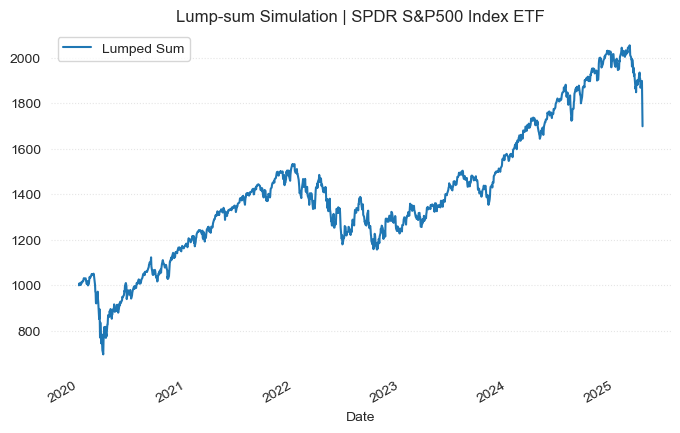

In [47]:
fig, ax = plt.subplots(figsize = (8, 5))
lump_sum.plot(ax = ax, label = 'Lumped Sum')
for spine in ax.spines.values():
    spine.set_visible(False)
ax.grid(False)
ax.yaxis.grid(True, ls = ':', alpha = 0.5) 
plt.legend()
plt.title('Lump-sum Simulation | SPDR S&P500 Index ETF')
plt.show()

### 2. Installment

Installment(적립식) 시뮬레이션은 일정 금액을 정기적으로 투자하여 가격 변동성을 줄이고 평균 매입 단가를 낮추는 전략이다. 주가가 상승할 때는 적은 수량을, 하락할 때는 많은 수량을 매수하여 시장 타이밍에 의존하지 않고 꾸준히 투자할 수 있다. 장기 투자 관점에서 시장 변동성을 자연스럽게 흡수하여 안정적인 자산 축적이 가능하여 성과가 과대 평가되며, 강한 상승장에서는 일시불 투자(Lump-Sum)보다 수익이 과소 평가되는 특징이 있다. 주로 자산운용사의 혹은 증권사의 상품 설명에서 쉽게 볼 수 있다.

**진입일 계산**

월 마지막 영업일에 종가로 진입을 한다고 가정한다. 그러기 위해서는 주어진 데이터에서 마지막 영업일을 우선 구해야 한다.

In [48]:
last_day_idx = data.groupby(data.index.to_period("M")).tail(1).index # 월 마지막 영업일

**floating shares**

지수 산정 혹은 간단한 역사적 시뮬레이션은 주식의 소유가 소수점 단위로 보유할 수 있도록 가정한다. 장점으로는 계산이 간편하다는 점이고, 단점으로는 정교한 시뮬레이션이 불가능해 성과가 왜곡될 수 있다는 점이다.

In [49]:
invest_amount = 1000  # 매월 1000달러씩 투자한다고 가정

investment_log = pd.DataFrame(
    dtype=float,
    index=last_day_idx,
    columns=[
        'investment_amount', 'net_purchase_amount',
        'num_security', 'cumsum_security',
        'price', 'average_purchase_price',
        'portfolio_value'
    ]
)

# 포트폴리오 가치
installment_portfolio = pd.DataFrame(index=data.index)
installment_portfolio['price'] = data['Close']
installment_portfolio['traded_value'] = np.nan
installment_portfolio['cumsum_security'] = 0.0
installment_portfolio['net_purchase_amount'] = 0.0
installment_portfolio['portfolio_value'] = 0.0

# 누적 변수
cumsum_security = 0
cumsum_amount = 0

for idx in data.index:
    if idx in last_day_idx: # 월말, 즉 투자하기로 한 날에만 이 계산이 이뤄진다.
        price = data.loc[idx, 'Close'] # 가격 (진입시점 혹은 투자시점)
        num_security = invest_amount / price # 월마다 설정한 금액에서 가격을 나눔 -> 구매한 증권 개수 
        cumsum_security += num_security # 총 구매한 증권 개수
        cumsum_amount += invest_amount # 총 투자한 금액

        investment_log.loc[idx, 'investment_amount'] = invest_amount
        investment_log.loc[idx, 'net_purchase_amount'] = cumsum_amount
        investment_log.loc[idx, 'num_security'] = num_security
        investment_log.loc[idx, 'cumsum_security'] = cumsum_security
        investment_log.loc[idx, 'price'] = price
        investment_log.loc[idx, 'average_purchase_price'] = cumsum_amount / cumsum_security
        investment_log.loc[idx, 'portfolio_value'] = cumsum_security * price

    # 일별로 포트폴리오 가치 업데이트
    installment_portfolio.loc[idx, 'cumsum_security'] = cumsum_security
    installment_portfolio.loc[idx, 'traded_value'] = num_security
    installment_portfolio.loc[idx, 'net_purchase_amount'] = cumsum_amount
    installment_portfolio.loc[idx, 'portfolio_value'] = cumsum_security * data.loc[idx, 'Close'] # 현재 보유중인 증권의 개수에 종가를 곱한다

In [50]:
investment_log # 거래 기록

,investment_amount,net_purchase_amount,num_security,cumsum_security,price,average_purchase_price,portfolio_value
Date,,,,,,,
2019-12-31,1000.0,1000.0,3.361240,3.361240,297.509277,297.509277,1000.000000
2020-01-31,1000.0,2000.0,3.362598,6.723838,297.389099,297.449176,1999.596052
2020-02-28,1000.0,3000.0,3.651685,10.375523,273.846161,289.142049,2841.297155
2020-03-31,1000.0,4000.0,4.172741,14.548264,239.650635,274.946895,3486.500686
2020-04-30,1000.0,5000.0,3.702575,18.250839,270.082275,273.960003,4929.228225
...,...,...,...,...,...,...,...
2024-12-31,1000.0,61000.0,1.711384,155.493143,584.322266,392.300257,90858.105633
2025-01-31,1000.0,62000.0,1.666625,157.159768,600.015015,394.503000,94298.220502
2025-02-28,1000.0,63000.0,1.688054,158.847822,592.397949,396.606003,94101.124266


In [51]:
installment_portfolio

,price,traded_value,cumsum_security,net_purchase_amount,portfolio_value
Date,,,,,
2019-12-31,297.509277,3.361240,3.361240,1000.0,1000.000000
2020-01-02,300.291595,3.361240,3.361240,1000.0,1009.352038
2020-01-03,298.017731,3.361240,3.361240,1000.0,1001.709034
2020-01-06,299.154663,3.361240,3.361240,1000.0,1005.530536
2020-01-07,298.313538,3.361240,3.361240,1000.0,1002.703312
...,...,...,...,...,...
2025-03-31,559.390015,1.787662,160.635484,64000.0,89857.885736
2025-04-01,560.969971,1.787662,160.635484,64000.0,90111.682741
2025-04-02,564.520020,1.787662,160.635484,64000.0,90681.946553


In [52]:
installment = (installment_portfolio['portfolio_value'] / installment_portfolio['net_purchase_amount']) * 1000

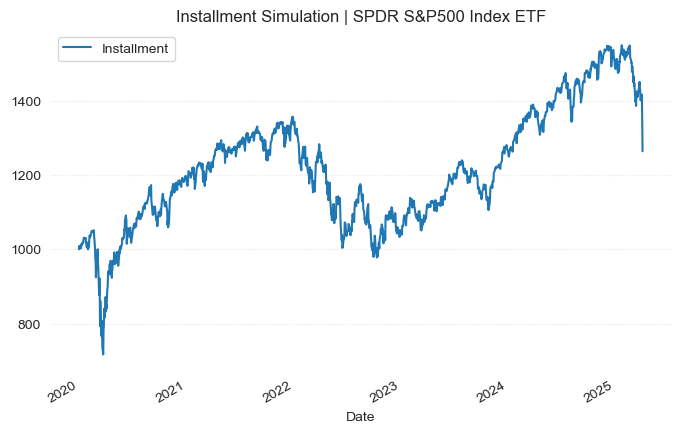

In [53]:
fig, ax = plt.subplots(figsize = (8, 5))
installment.plot(ax = ax, label = 'Installment')
for spine in ax.spines.values():
    spine.set_visible(False)
ax.grid(False)
ax.yaxis.grid(True, ls = ':', alpha = 0.5) 
plt.legend()
plt.title('Installment Simulation | SPDR S&P500 Index ETF')
plt.show()

In [54]:
invest_amount = 1000  # 매월 1000달러씩 투자한다고 가정

# 월말 투자 기록용 로그
investment_log = pd.DataFrame(
    dtype=float,
    index=last_day_idx,
    columns=[
        'investment_amount', 'net_purchase_amount',
        'num_security', 'cumsum_security',
        'price', 'average_purchase_price',
        'portfolio_value', 'cash'
    ]
)

# 일별 포트폴리오 가치 추적용 로그
installment_int_portfolio = pd.DataFrame(index=data.index)
installment_int_portfolio['price'] = data['Close']
installment_int_portfolio['traded_value'] = np.nan
installment_int_portfolio['cumsum_security'] = 0
installment_int_portfolio['net_purchase_amount'] = 0.0
installment_int_portfolio['portfolio_value'] = 0.0
installment_int_portfolio['cash'] = 0.0

# 누적 변수
cumsum_security = 0  # 누적 주식 수
cumsum_amount = 0    # 누적 투자금
cash = 0.0           # 현금 보유

for idx in data.index:
    # 월말 투자 (정기적 투자)
    if idx in last_day_idx:
        price = data.loc[idx, 'Close']
        # 매수 가능한 주식 수 (정수)
        num_security = int(invest_amount // price)
        # 남는 현금 계산
        cash += invest_amount - (num_security * price)
        
        # 누적 계산
        cumsum_security += num_security
        cumsum_amount += num_security * price

        # 투자 기록 업데이트
        investment_log.loc[idx, 'investment_amount'] = invest_amount
        investment_log.loc[idx, 'net_purchase_amount'] = cumsum_amount
        investment_log.loc[idx, 'num_security'] = num_security
        investment_log.loc[idx, 'cumsum_security'] = cumsum_security
        investment_log.loc[idx, 'price'] = price
        investment_log.loc[idx, 'average_purchase_price'] = cumsum_amount / cumsum_security
        investment_log.loc[idx, 'portfolio_value'] = cumsum_security * price + cash
        investment_log.loc[idx, 'cash'] = cash

    # 매일 현금 활용하여 추가 매수 가능 여부 확인
    price = data.loc[idx, 'Close']
    # # 현금이 충분할 경우 추가 매수
    # while cash >= price:
    #     num_security = int(cash // price)  # 살 수 있는 최대 정수 주식 수
    #     cash -= num_security * price
    #     cumsum_security += num_security

    # 일별로 포트폴리오 가치 업데이트
    installment_int_portfolio.loc[idx, 'cumsum_security'] = cumsum_security
    installment_int_portfolio.loc[idx, 'traded_value'] = num_security
    installment_int_portfolio.loc[idx, 'net_purchase_amount'] = cumsum_amount
    installment_int_portfolio.loc[idx, 'portfolio_value'] = cumsum_security * data.loc[idx, 'Close'] + cash
    installment_int_portfolio.loc[idx, 'cash'] = cash


In [55]:
installment_int_portfolio

,price,traded_value,cumsum_security,net_purchase_amount,portfolio_value,cash
Date,,,,,,
2019-12-31,297.509277,3.0,3,892.527832,1000.000000,107.472168
2020-01-02,300.291595,3.0,3,892.527832,1008.346954,107.472168
2020-01-03,298.017731,3.0,3,892.527832,1001.525360,107.472168
2020-01-06,299.154663,3.0,3,892.527832,1004.936157,107.472168
2020-01-07,298.313538,3.0,3,892.527832,1002.412781,107.472168
...,...,...,...,...,...,...
2025-03-31,559.390015,1.0,127,49604.486938,85438.044922,14395.513062
2025-04-01,560.969971,1.0,127,49604.486938,85638.699341,14395.513062
2025-04-02,564.520020,1.0,127,49604.486938,86089.555542,14395.513062


In [56]:
install_int = installment_int_portfolio['portfolio_value'] / (installment_int_portfolio['net_purchase_amount'] + installment_int_portfolio['cash']) * 1000

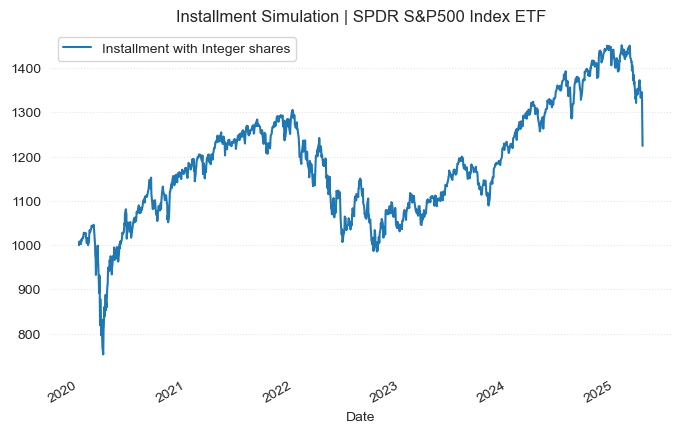

In [57]:
fig, ax = plt.subplots(figsize = (8, 5))
install_int.plot(ax = ax, label = 'Installment with Integer shares')
for spine in ax.spines.values():
    spine.set_visible(False)
ax.grid(False)
ax.yaxis.grid(True, ls = ':', alpha = 0.5) 
plt.legend()
plt.title('Installment Simulation | SPDR S&P500 Index ETF')
plt.show()

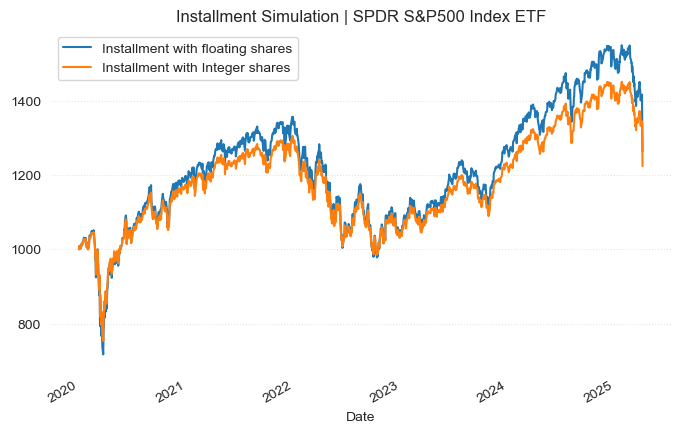

In [59]:
fig, ax = plt.subplots(figsize = (8, 5))
installment.plot(ax = ax, label = 'Installment with floating shares')
install_int.plot(ax = ax, label = 'Installment with Integer shares')
for spine in ax.spines.values():
    spine.set_visible(False)
ax.grid(False)
ax.yaxis.grid(True, ls = ':', alpha = 0.5) 
plt.legend()
plt.title('Installment Simulation | SPDR S&P500 Index ETF')
plt.show()

### 3. Cost Average Simulation

In [60]:
invest_shares = 10  # 매월 10주씩 투자한다고 가정

# 월말 투자 기록용 로그
investment_log = pd.DataFrame(
    dtype=float,
    index=last_day_idx,
    columns=[
        'investment_shares', 'net_purchase_amount',
        'num_security', 'cumsum_security',
        'price', 'average_purchase_price',
        'portfolio_value', 'cash'
    ]
)

# 일별 포트폴리오 가치 추적용 로그
cost_average_portfolio = pd.DataFrame(index=data.index)
cost_average_portfolio['price'] = data['Close']
cost_average_portfolio['traded_value'] = np.nan
cost_average_portfolio['cumsum_security'] = 0
cost_average_portfolio['net_purchase_amount'] = 0.0
cost_average_portfolio['portfolio_value'] = 0.0
cost_average_portfolio['cash'] = 0.0

# 누적 변수
cumsum_security = 0  # 누적 주식 수
cumsum_amount = 0    # 누적 투자금
cash = 0.0           # 현금 보유

for idx in data.index:
    if idx in last_day_idx:
        price = data.loc[idx, 'Close']
        # 한 달에 일정 수량을 매수
        num_security = invest_shares
        # 투자 금액 계산
        invest_amount = num_security * price

        # 잔여 현금 계산
        if cash >= invest_amount:
            cash -= invest_amount
        else:
            cash = 0

        # 누적 계산
        cumsum_security += num_security
        cumsum_amount += invest_amount

        # 투자 기록 업데이트
        investment_log.loc[idx, 'investment_shares'] = invest_shares
        investment_log.loc[idx, 'net_purchase_amount'] = cumsum_amount
        investment_log.loc[idx, 'num_security'] = num_security
        investment_log.loc[idx, 'cumsum_security'] = cumsum_security
        investment_log.loc[idx, 'price'] = price
        investment_log.loc[idx, 'average_purchase_price'] = cumsum_amount / cumsum_security
        investment_log.loc[idx, 'portfolio_value'] = cumsum_security * price + cash
        investment_log.loc[idx, 'cash'] = cash

    # 일별로 포트폴리오 가치 업데이트
    cost_average_portfolio.loc[idx, 'cumsum_security'] = cumsum_security
    cost_average_portfolio.loc[idx, 'traded_value'] = num_security
    cost_average_portfolio.loc[idx, 'net_purchase_amount'] = cumsum_amount
    cost_average_portfolio.loc[idx, 'portfolio_value'] = cumsum_security * data.loc[idx, 'Close'] + cash
    cost_average_portfolio.loc[idx, 'cash'] = cash

In [61]:
cost_average = cost_average_portfolio['portfolio_value'] / cost_average_portfolio['net_purchase_amount'] * 1000

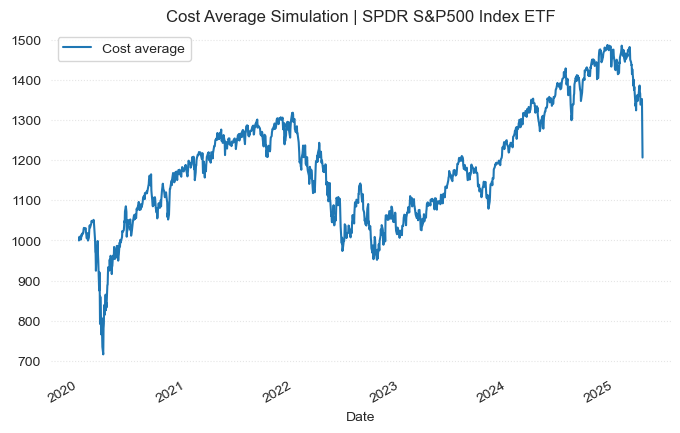

In [62]:
fig, ax = plt.subplots(figsize = (8, 5))
cost_average.plot(ax = ax, label = 'Cost average')
for spine in ax.spines.values():
    spine.set_visible(False)
ax.grid(False)
ax.yaxis.grid(True, ls = ':', alpha = 0.5) 
plt.legend()
plt.title('Cost Average Simulation | SPDR S&P500 Index ETF')
plt.show()

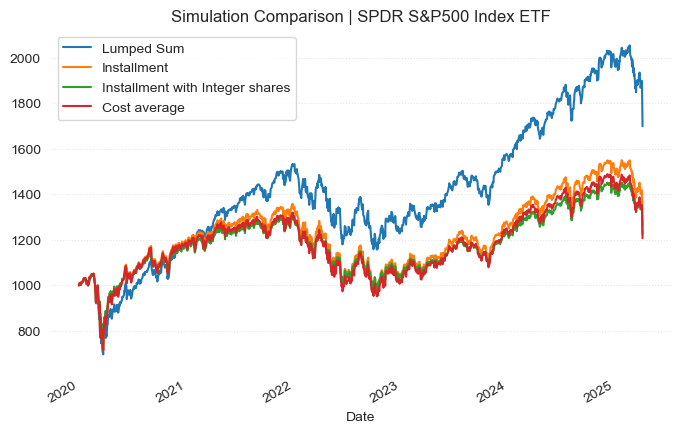

In [63]:
fig, ax = plt.subplots(figsize = (8, 5))
lump_sum.plot(ax = ax, label = 'Lumped Sum')
installment.plot(ax = ax, label = 'Installment')
install_int.plot(ax = ax, label = 'Installment with Integer shares')
cost_average.plot(ax = ax, label = 'Cost average')
for spine in ax.spines.values():
    spine.set_visible(False)
ax.grid(False)
ax.yaxis.grid(True, ls = ':', alpha = 0.5) 
plt.legend()
plt.title('Simulation Comparison | SPDR S&P500 Index ETF')
plt.show()

### 4. Trading Costs

거래비용 (증권사 수수료, tax), 유동성 비용, slippage

**Liquidity Cost**

유동성 비용은 거래됐던 날의 장부를 직접 열람하지 않는 이상 정확한 추정은 거의 불가능에 가깝다. 대신, 그에 대한 대용치로 고가 저가 스프레드를 추정하여 유동성 비용을 추정한다. 아래와 같은 프로세스로 계산된다

1. 과거 가격 데이터에서 고가-저가 스프레드를 이용하여 유동성 비용 추정

$$c = 2\left( \sqrt{\frac{\beta}{2}} - \sqrt{\frac{\beta}{2} - \gamma}\right)$$
$$\beta = \frac{2(H_t - L_t)^2}{1-\frac{1}{n}}$$
$$\gamma = \frac{(H_t -L_{t-1})(H_{t-1} - L_t)}{1 - \frac{1}{n}}$$

2. 과거 거래량 데이터를 활용하여 거래 비용을 보정

$$\text{Liquidity Cost} = c \times \text{Trade Volume}$$

3. 매매 시점별 유동성 비용을 고려하여 포트폴리오 수익률 조정

$$\text{Adjested Return} = r_t - \frac{\text{Liquidity Cost}}{\text{Portfolio Value}}$$

1번의 spread는 corwin schultz spread로, `FinancialMachineLearning` Library에서 사용 가능하다.

In [64]:
from FinancialMachineLearning.features.microstructure import corwin_schultz_estimator

In [65]:
spread = corwin_schultz_estimator(
    high = data['High'],
    low = data['Low'],
    window = 2
)

In [66]:
liquidity_cost = spread * installment_portfolio['traded_value']

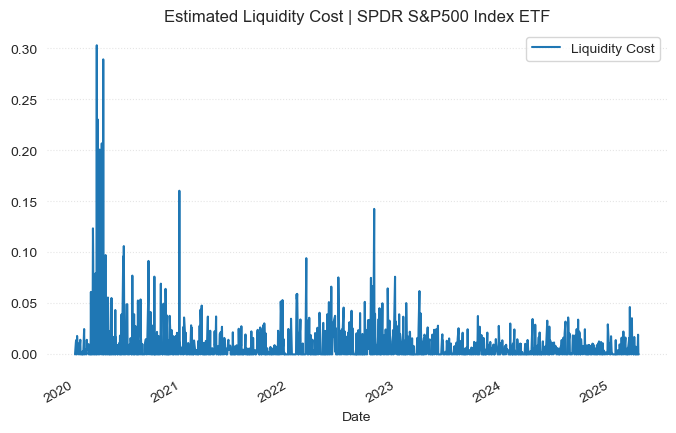

In [67]:
fig, ax = plt.subplots(figsize = (8, 5))
liquidity_cost.plot(ax = ax, label = 'Liquidity Cost')
for spine in ax.spines.values():
    spine.set_visible(False)
ax.grid(False)
ax.yaxis.grid(True, ls = ':', alpha = 0.5) 
plt.legend()
plt.title('Estimated Liquidity Cost | SPDR S&P500 Index ETF')
plt.show()

In [68]:
liquidity_ret = (liquidity_cost.loc[last_day_idx] / (installment_portfolio.loc[last_day_idx, 'price'] * installment_portfolio.loc[last_day_idx, 'traded_value']))

In [69]:
installment_ret = installment.pct_change()

In [70]:
installment_ret.loc[liquidity_ret.index] = installment.pct_change().loc[liquidity_ret.index] - liquidity_ret

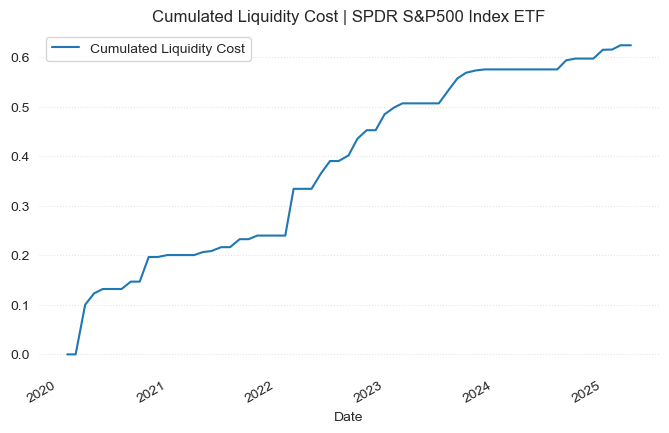

In [71]:
fig, ax = plt.subplots(figsize = (8, 5))
liquidity_cost.loc[last_day_idx].cumsum().plot(ax = ax, label = 'Cumulated Liquidity Cost')
for spine in ax.spines.values():
    spine.set_visible(False)
ax.grid(False)
ax.yaxis.grid(True, ls = ':', alpha = 0.5) 
plt.legend()
plt.title('Cumulated Liquidity Cost | SPDR S&P500 Index ETF')
plt.show()

**Slippage**

$$s_t = \frac{\text{Traded Value}_t}{\nu_t \times p_t}$$
$$\text{Adjested Return} = r_t - \frac{s_t}{\text{Portfolio Value}_t}$$

여기서 $s_t$는 t시점의 slippage,$\nu_t$는 t 시점의 거래량, $p_t$는 t 시점의 종가이다.

In [72]:
slippage = ((installment_portfolio['traded_value'] * installment_portfolio['price']) / (data['Volume'] * data['Close'])).loc[last_day_idx]

In [73]:
slippage_ret = slippage / installment_portfolio['portfolio_value']

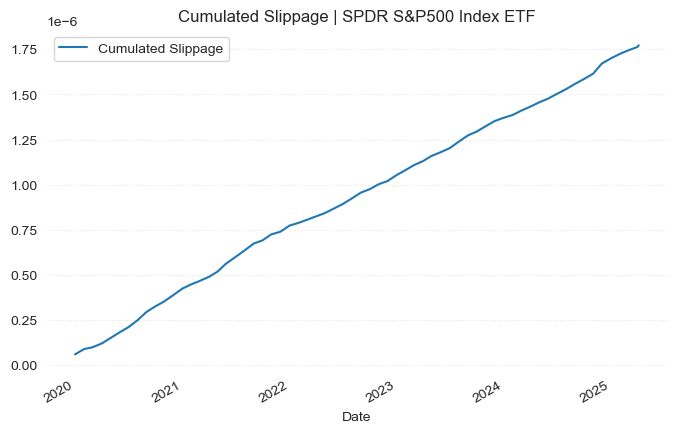

In [74]:
fig, ax = plt.subplots(figsize = (8, 5))
slippage.cumsum().plot(ax = ax, label = 'Cumulated Slippage')
for spine in ax.spines.values():
    spine.set_visible(False)
ax.grid(False)
ax.yaxis.grid(True, ls = ':', alpha = 0.5) 
plt.legend()
plt.title('Cumulated Slippage | SPDR S&P500 Index ETF')
plt.show()

### 5. Asset Returns

#### 5.1 Simple Asset Return

- 배당이 존재하는 경우
$$r_t = \frac{P_t - P_{t-1} + D_t}{P_{t-1}}$$ 

- 배당이 존재하지 않는 경우
$$r_t = \frac{P_t - P_{t-1}}{P_{t-1}}$$

In [75]:
asset_return = installment.pct_change()

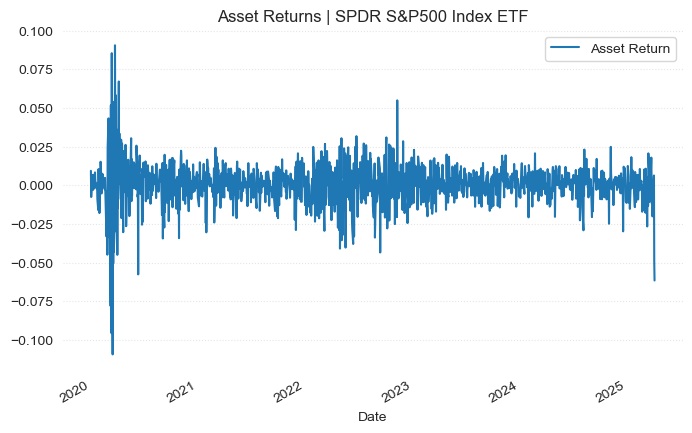

In [77]:
fig, ax = plt.subplots(figsize = (8, 5))
asset_return.plot(ax = ax, label = 'Asset Return')
for spine in ax.spines.values():
    spine.set_visible(False)
ax.grid(False)
ax.yaxis.grid(True, ls = ':', alpha = 0.5) 
plt.legend()
plt.title('Asset Returns | SPDR S&P500 Index ETF')
plt.show()

#### 5.2 Internal Rate

Internal Rate of Return (IRR)은 투자 프로젝트의 순현재가치(NPV)를 0으로 만드는 할인율로, 투자로부터 기대할 수 있는 연평균 수익률을 의미한다. 

$$\text{NPV} = \sum_{t=1}^n \frac{C_t}{(1+r)^t} = 0$$

투자와 회수의 현금 흐름이 모두 존재할 때 유효하며, 매수만 있는 경우에는 CAGR(연평균 성장률)을 활용하여 수익성을 평가한다. IRR이 양수면 수익성 있는 투자로 간주되며, 여러 IRR이 존재하거나 계산이 불가능한 경우도 있어 주의가 필요하다.

이 케이스에서는 우선 매수만 있기 때문에, 추후 실습으로 넘어가도록 한다.

#### 5.3 Time Weighted Average Return

**Time-Weighted Average Return (TWAR)** 은 현금 흐름의 영향을 제거하여 순수하게 투자 성과를 평가하는 수익률이다. 펀드 매니저의 운용 성과를 평가할 때 주로 사용하며, 현금 유입/유출이 빈번한 포트폴리오에 적합하다. TWAR은 각 기간의 수익률을 기하 평균하여 구한다.

$$\text{TWAR} = \prod_{t=1}^n (1+r_t) - 1$$

TWAR은 다음과 같은 특징이 있어 많이 사용된다.
- 현금 유입/유출의 영향을 제거하여 순수 운용 성과를 평가할 수 있다
- 포트폴리오 관리의 일관성을 측정하는 데 유리하다
- 거래나 리밸런싱이 잦은 경우에도 성과를 왜곡하지 않는다

### 6. Total Return

시뮬레이션은 종종 배당수익률의 영향을 받아서 왜곡될 수 있다. 시뮬레이션은 배당수익을 빼고 가격 변동만을 고려한 Price Return Fund와 배당수익을 재투자하는 것을 고려한 Total Return 형태가 존재한다. 배당수익률은 작아 보이지만 복리 효과가 존재하기 때문에 배당수익률을 고려한 시뮬레이션과 고려하지 않은 시뮬레이션을 서로 비교할 경우 성과를 왜곡할 수도 있다.

yahoo finance에서는 `auto_adjust` parameter를 통해 배당 할인을 고려한 가격과 배당 할인을 하지 않은 가격을 가져올 수 있다. yahoo finance에서는 액면 분할에 대한 조정은 모두 적용되어 있으므로, 수정 종가 가격은 배당 할인 계수와 액면 분할 조정 계수 둘 다 포함되어 있는 것을 알아 두자.

#### 6.1 Total Return Simulation

$$\pi = \prod_{t=1}^n \left(1 + \frac{P_t - P_{t-1} + D_t}{P_{t-1}}\right)$$

In [78]:
spx_price = yf.download(
    'SPY',
    start = '2019-12-31',
    progress = False,
    interval = '1d',
    multi_level_index = False,
    auto_adjust = False # False인 경우, 배당할인이 들어가지 않은 가격을 가져오도록 한다
)

In [79]:
dividend_rate = data['Close'].pct_change() - spx_price['Close'].pct_change()

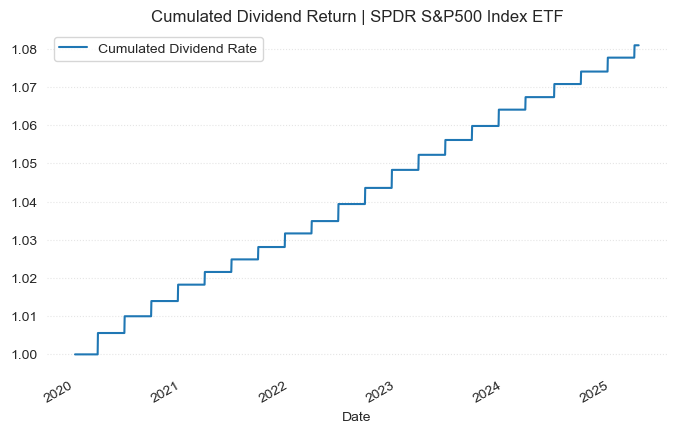

In [80]:
fig, ax = plt.subplots(figsize = (8, 5))
(1 + np.round(dividend_rate, 5)).cumprod().plot(ax = ax, label = 'Cumulated Dividend Rate')
for spine in ax.spines.values():
    spine.set_visible(False)
ax.grid(False)
ax.yaxis.grid(True, ls = ':', alpha = 0.5) 
plt.legend()
plt.title('Cumulated Dividend Return | SPDR S&P500 Index ETF')
plt.show()

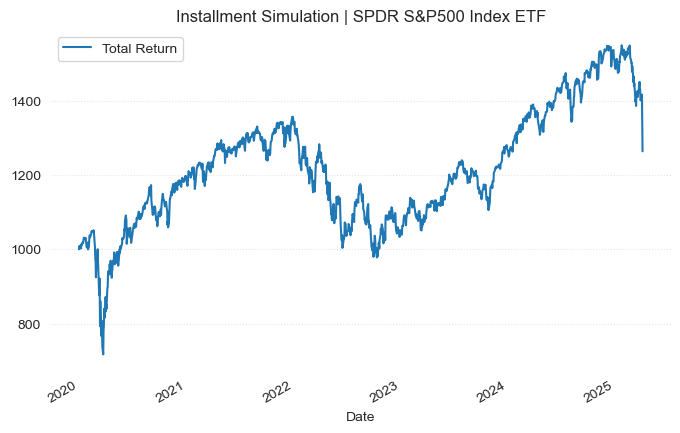

In [81]:
fig, ax = plt.subplots(figsize = (8, 5))
installment.plot(ax = ax, label = 'Total Return')
for spine in ax.spines.values():
    spine.set_visible(False)
ax.grid(False)
ax.yaxis.grid(True, ls = ':', alpha = 0.5) 
plt.legend()
plt.title('Installment Simulation | SPDR S&P500 Index ETF')
plt.show()

#### 6.2 Price Return Simulation

$$\pi = \prod_{t=1}^n \left(1 + \frac{P_t - P_{t-1}}{P_{t-1}}\right)$$

In [82]:
invest_amount = 1000  # 매월 1000달러씩 투자한다고 가정

investment_log = pd.DataFrame(
    dtype=float,
    index=last_day_idx,
    columns=[
        'investment_amount', 'net_purchase_amount',
        'num_security', 'cumsum_security',
        'price', 'average_purchase_price',
        'portfolio_value'
    ]
)

# 포트폴리오 가치
installment_pr_portfolio = pd.DataFrame(index=spx_price.index)
installment_pr_portfolio['price'] = spx_price['Close']
installment_pr_portfolio['traded_value'] = np.nan
installment_pr_portfolio['cumsum_security'] = 0.0
installment_pr_portfolio['net_purchase_amount'] = 0.0
installment_pr_portfolio['portfolio_value'] = 0.0

# 누적 변수
cumsum_security = 0
cumsum_amount = 0

for idx in spx_price.index:
    if idx in last_day_idx:
        price = spx_price.loc[idx, 'Close']
        num_security = invest_amount / price
        cumsum_security += num_security
        cumsum_amount += invest_amount

        investment_log.loc[idx, 'investment_amount'] = invest_amount
        investment_log.loc[idx, 'net_purchase_amount'] = cumsum_amount
        investment_log.loc[idx, 'num_security'] = num_security
        investment_log.loc[idx, 'cumsum_security'] = cumsum_security
        investment_log.loc[idx, 'price'] = price
        investment_log.loc[idx, 'average_purchase_price'] = cumsum_amount / cumsum_security
        investment_log.loc[idx, 'portfolio_value'] = cumsum_security * price

    # 일별로 포트폴리오 가치 업데이트
    installment_pr_portfolio.loc[idx, 'cumsum_security'] = cumsum_security
    installment_pr_portfolio.loc[idx, 'traded_value'] = num_security
    installment_pr_portfolio.loc[idx, 'net_purchase_amount'] = cumsum_amount
    installment_pr_portfolio.loc[idx, 'portfolio_value'] = cumsum_security * spx_price.loc[idx, 'Close']

In [83]:
installment_pr = (installment_pr_portfolio['portfolio_value'] / installment_pr_portfolio['net_purchase_amount']) * 1000

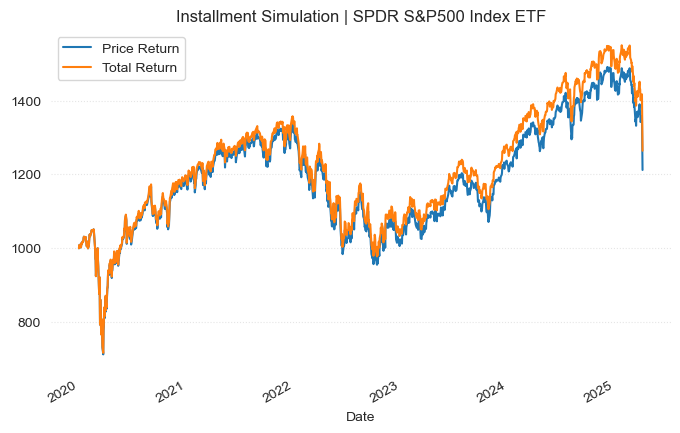

In [84]:
fig, ax = plt.subplots(figsize = (8, 5))
installment_pr.plot(ax = ax, label = 'Price Return')
installment.plot(ax = ax, label = 'Total Return')
for spine in ax.spines.values():
    spine.set_visible(False)
ax.grid(False)
ax.yaxis.grid(True, ls = ':', alpha = 0.5) 
plt.legend()
plt.title('Installment Simulation | SPDR S&P500 Index ETF')
plt.show()